In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
from collections import OrderedDict

In [41]:
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [42]:
from data_gen import *
from model_v2 import *
from yash_model import *

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Gen

In [44]:
X_train, y_train = get_train_data([5000,5000])
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=20)

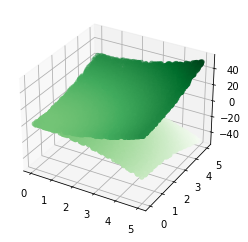

In [45]:
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,0], X_train[:,1], y_train, c=y_train, cmap='Greens');

## Model

In [46]:
cat_dims = [2]
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]


In [47]:
model = FeedForward(emb_dims=[], no_of_cont=2, lin_layer_sizes=[50,100], output_size=1, emb_dropout=0.04, lin_layer_dropouts=[0.001, 0.01])

n_epochs = 100
loss_values = []
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)


# Uncomment this for sequential model.
# model = nn.Sequential(OrderedDict([
#         ('bn1', nn.BatchNorm1d(2)),
#         ('lin1', nn.Linear(2, 1000)),
#         ('relu1', nn.ReLU()),
#         ('bn2', nn.BatchNorm1d(1000)),
#         ('lin2', nn.Linear(1000,500)),
#         ('relu2', nn.ReLU()),
#         ('bn3', nn.BatchNorm1d(500)),
#         ('lin3', nn.Linear(500, 1)),
# ]))

for epoch in range(n_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        cont_x = inputs[:,:2].float()
        cat_x = inputs[:,2:].float()

        preds = model(cont_x, cat_x)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item():.3f}")
    loss_values.append(loss.item())

Epoch 0/100, Loss: 487.829
Epoch 1/100, Loss: 302.240
Epoch 2/100, Loss: 285.813
Epoch 3/100, Loss: 288.899
Epoch 4/100, Loss: 397.559
Epoch 5/100, Loss: 414.238
Epoch 6/100, Loss: 300.649
Epoch 7/100, Loss: 287.779
Epoch 8/100, Loss: 456.496
Epoch 9/100, Loss: 438.511
Epoch 10/100, Loss: 264.440
Epoch 11/100, Loss: 221.515
Epoch 12/100, Loss: 386.834
Epoch 13/100, Loss: 415.625
Epoch 14/100, Loss: 321.056
Epoch 15/100, Loss: 316.716
Epoch 16/100, Loss: 359.602
Epoch 17/100, Loss: 320.609
Epoch 18/100, Loss: 552.178
Epoch 19/100, Loss: 367.312
Epoch 20/100, Loss: 422.783
Epoch 21/100, Loss: 302.921
Epoch 22/100, Loss: 387.842
Epoch 23/100, Loss: 343.435
Epoch 24/100, Loss: 337.986
Epoch 25/100, Loss: 229.193
Epoch 26/100, Loss: 323.484
Epoch 27/100, Loss: 399.040
Epoch 28/100, Loss: 418.438
Epoch 29/100, Loss: 318.641
Epoch 30/100, Loss: 367.113
Epoch 31/100, Loss: 399.104
Epoch 32/100, Loss: 622.558
Epoch 33/100, Loss: 226.645
Epoch 34/100, Loss: 521.817
Epoch 35/100, Loss: 352.921
Ep

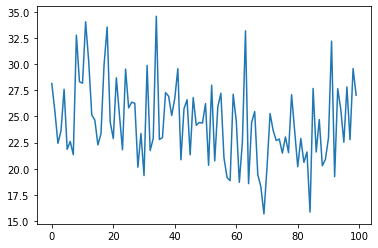

In [9]:
plt.plot(np.array(np.arange(0, n_epochs)), loss_values)
